# XGBoost regressor 

In [1]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance

import xgboost as xgb

In [2]:
# Current versions of XGBoost and Seaborn have a FutureWarning bug; suppress with this
# warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# Set max number of columns to display; default 20
pd.options.display.max_columns = 50

In [4]:
# Paths to data directories
cwd_path = Path.cwd()
data_path = cwd_path.parent.joinpath('data')
data_push_path = cwd_path.parent.joinpath('data_to_push')

#### Read in data (and wrangle a bit)

In [5]:
df = pd.read_pickle(data_push_path / 'df_main_smard_era5_final_reordered.pkl')

# Split off SMARD forecasted and actuals into separate dataframe and drop SMARD forecasted
df_smard_preds_vs_actuals = df.loc[:, ['forecasted_generation_smard_mwh', 'actual_generated_smard_mwh']].copy()
df.drop(columns=['forecasted_generation_smard_mwh'], inplace=True)

# Add column of pure random noise which will be used for comparison in feature importance analysis later
# Random values between 0 and 1
df['noise'] = np.random.rand(df.shape[0])

# Back fill the 6_550 missing values in day-ahead price feature; random forest regressor doesn't handle NaNs!
df['day_ahead_price_eur_mwh'].fillna(method='bfill', inplace=True)

# Drop total_nominal_capacity_smard_mw as it has yearly temporal resolution and my version has quasi-daily
df.drop(columns=['total_nominal_capacity_smard_mw'], inplace=True)

# df.info()

In [6]:
# Separate these ERA5 and ERA5-derived param groups for quicker selections later

# My 9 weighted ERA5 features
weighted_wx_features = [
    'weighted_temp_2m_celsius',
    'weighted_mean_sea_level_pressure_mb',
    'weighted_wind_gusts_10m',
    'weighted_mean_wind_speed_10m',
    'weighted_mean_wind_speed_100m',
    'weighted_mean_wind_direction_angle_10m',
    'weighted_mean_wind_direction_angle_100m',
    'weighted_wind_direction_intercardinal_10m',
    'weighted_wind_direction_intercardinal_100m',
]

# My 9 unweighted ERA5 features
unweighted_wx_features = [
    'temp_2m_celsius',
    'mean_sea_level_pressure_mb',
    'wind_gusts_10m',
    'mean_wind_speed_10m',
    'mean_wind_speed_100m',
    'wind_direction_angle_10m',
    'wind_direction_angle_100m',
    'wind_direction_intercardinal_10m',
    'wind_direction_intercardinal_100m',
]

# Create separate dataframes as well
df_weighted = df.loc[:, ~df.columns.isin(unweighted_wx_features)].copy()
df_unweighted = df.loc[:, ~df.columns.isin(weighted_wx_features)].copy()

-----

## Gradient boosted tree regressor 
- Three sets: train, validation, and a hold-out test set
- Go with a rolling window approach using TimeSeriesSplit to cap computational cost of cross-validation

#### Set aside a hold-out test sets for `df_weighted` and `df_unweighted`
- Everything after 2023-01-01 (so I can compare with random forest baseline RMSE score)

In [7]:
split_date = '2023-01-01'

# Set aside a hold-out test set (all timestamps in 2023)
# This is the unseen data that I will use to make predictions using the final model
df_hold_out_test_set_weighted = df_weighted.loc[df_weighted.index >= split_date].copy()
df_hold_out_test_set_unweighted = df_unweighted.loc[df_unweighted.index >= split_date].copy()

# Remove this hold-out set from the dataframes
df_weighted = df_weighted.loc[df_weighted.index < split_date].copy()
df_unweighted = df_unweighted.loc[df_unweighted.index < split_date].copy()

#### Visualise time series split I want to employ

In [53]:
def plot_time_series_split(df):
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Instantiate time series split
    tscv = TimeSeriesSplit(
        n_splits=5,
        gap=48,
        # Around 1 year and 2 months for each training split
        max_train_size=10_000,  # 8_760
        # test_size=1_000,
    )

    # Plot the splits
    fig, axes = plt.subplots(n_splits, figsize=(14, 10))

    # Loop through the splits and plot
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        ax = axes[i]
        
        # plot the target variable (actual power generated)
        ax.plot(y.index[train_index], y.iloc[train_index], 'tab:blue', label='Train')
        ax.plot(y.index[test_index], y.iloc[test_index], 'tab:red', label='Test')
        # set x axis limits
        ax.set_xlim(X.index.min(), X.index.max())
        # plot vertical line denoting where the split takes place
        ax.axvline(
            y.index[train_index][-1], color='black', linestyle='--', linewidth=2, alpha=1
        )

        ax.legend()
        ax.set_title(f'Fold {i}', fontweight='bold')
        ax.set_xlabel('date')
        ax.set_ylabel('Actual MWh')

    plt.tight_layout()
    plt.show()

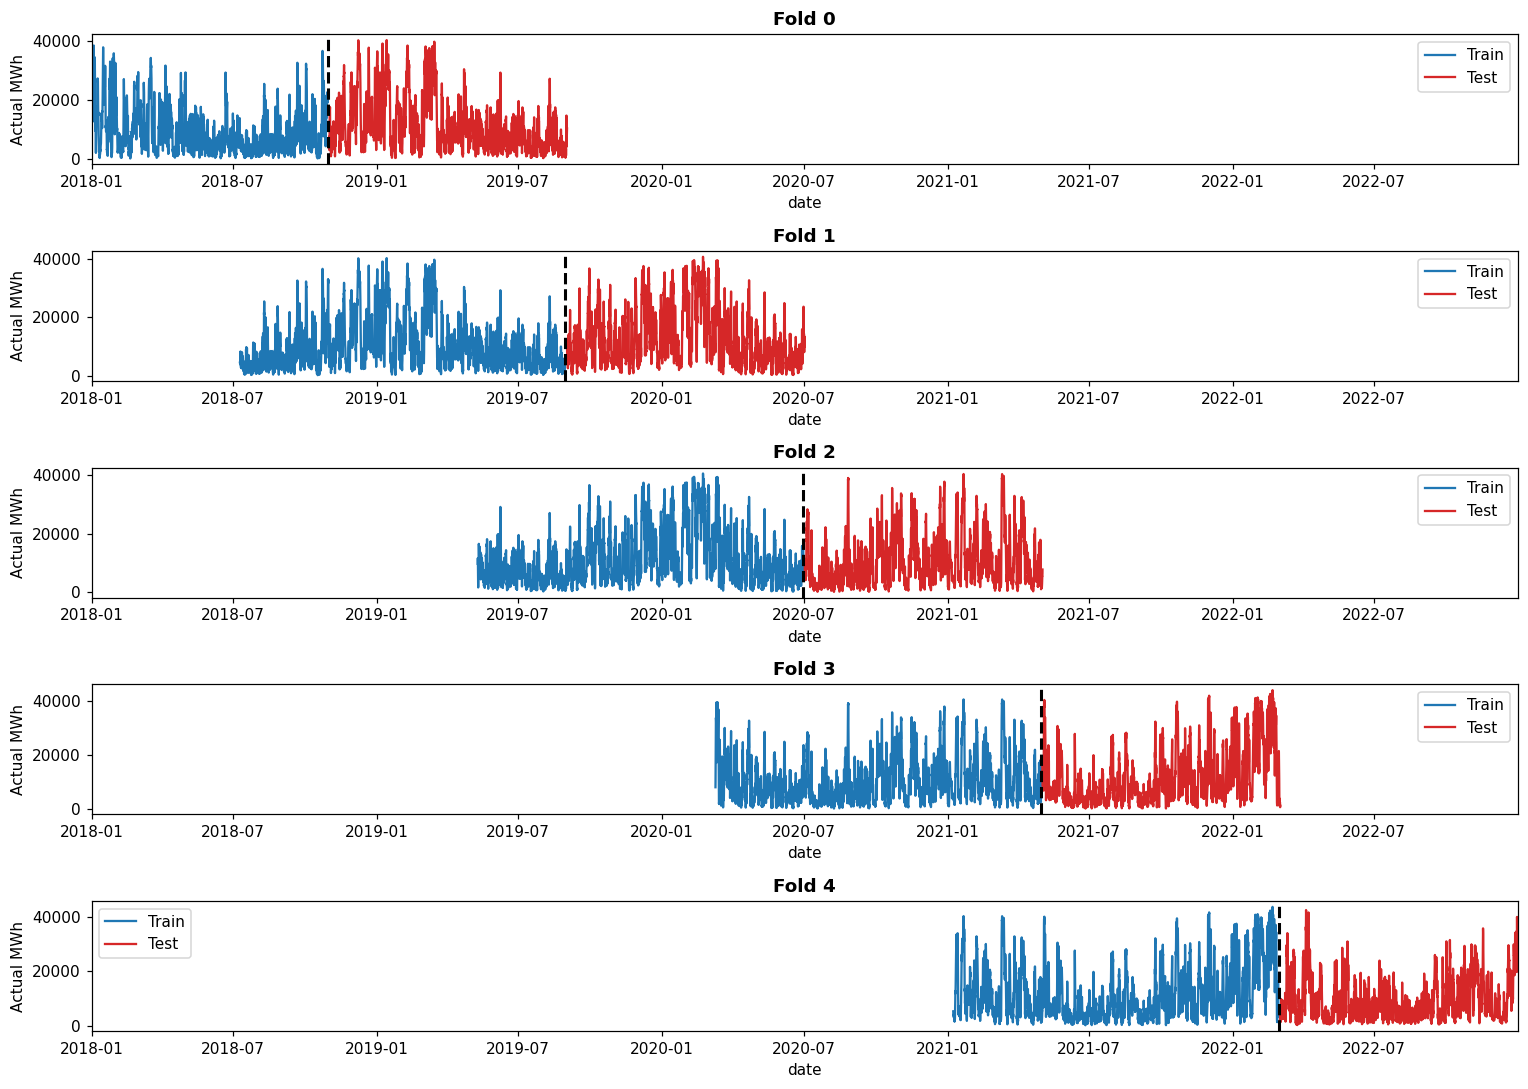

In [54]:
plot_time_series_split(df_unweighted)

In [8]:
# def create_pipeline_and_sets_using_df(df, n_splits=5):
#     """
#     Input is either the unweighted or weighted dataframe
#     Output is the pipeline object and X & y train-test sets
#     """
#     # Assign X & y using df; keep datetime as index and select indexes using .iloc
#     X = df.drop(columns=['actual_generated_smard_mwh']).copy()
#     y = df['actual_generated_smard_mwh'].copy()
    
#     # List of categorical features for ordinal encoding
#     # Get from df as column names depend on if using weighted or unweighted df
#     categorical_features = df.select_dtypes('category').columns.to_list()

#     # the unique values for each categorical feature; must be in order of list above
#     categories = [
#         # meteorological_season
#         ['winter', 'spring', 'summer', 'autumn'],
#         # wind_direction_intercardinal_10m
#         ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
#          'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
#         # wind_direction_intercardinal_100m
#         ['SW', 'WSW', 'SSW', 'S', 'W', 'SSE', 'SE', 'ESE', 
#          'E', 'ENE', 'NE', 'WNW', 'NW', 'NNW', 'NNE'],
#     ]

#     # Instantiate ordinal encoder and provide unique categories (could also use defaul of auto)
#     ordinal_encoder = OrdinalEncoder(categories=categories)
    
#     # Features to one-hot encode and instantiate one-hot encoder
#     one_hot_features = ['meteorological_season']
#     one_hot_features.extend(df.filter(regex='inter', axis=1).columns.to_list())
#     one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

#     # Create pipeline object with named steps
#     xgbr_pipeline = Pipeline([
#         # Step 1: run categorical features through ordinal encoder
#         ('transformer',
#             ColumnTransformer(
#             transformers=[
#                 ('categorical', ordinal_encoder, categorical_features),
#                 # ('one_hot', one_hot_encoder, one_hot_features),
#             ],
#             remainder='passthrough',
#             verbose_feature_names_out=False,
#         )),
#         # Step 2: instantiate random forest regressor
#         ('model', xgb.XGBRegressor(
#             n_estimators=1_000,
#             tree_method='hist',
#             max_depth=7,
#             learning_rate=0.2,
#             # early_stopping_rounds=50,
#             enable_categorical=False,
#             n_jobs=-1,
#         )),
#     ], verbose=2).set_output(transform='pandas')
    
    
#     # Initialise TimeSeriesSplit
#     tscv = TimeSeriesSplit(
#         n_splits=n_splits,
#     )
    
#     # List for storing each fold's RMSE score on validation set
#     rmse_scores = []
    
#     for train_index, validation_index in tscv.split(X):
#         X_train, X_validation = X.iloc[train_index], X.iloc[validation_index]
#         y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]

        
#         # fit model to the train data (via pipeline object)
#         xgbr_pipeline.fit(X_train, y_train)
        
#         # Fit the model
#         regr.fit(
#             X_train, y_train,
#             # evaluate RMSE on both train and test sets
#             # eval_set=[(X_train, y_train), (X_test, y_test)],
#             verbose=True 
#         )
        
#         # Predict on test fold
#         y_preds = regr.predict(X_test)
        
#         # Append RMSE of fold to list
#         rmse = np.sqrt(mean_squared_error(y_test, y_preds))
#         rmse_scores.append(rmse)
        
#     # mean_rmse = np.mean(rmse_scores)
    
# #     return rmse_scores

#     return xgbr_pipeline, X_train, y_train, X_test, y_test

-----

## Test new approach here
- Step 1: Use TimeSeriesSplit and GridSearchCV to find best hyperparameters
- Step 2: Use TimeSeriesSplit and early stopping + an eval_set to fit a final model
- Step 3: Make predictions for hold-out test set using final model
- Step 4: Plot predictions against actuals and show final RMSE

In [9]:
def rmse(y_true, y_preds):
    return np.sqrt(mean_squared_error(y_true, y_preds))

In [30]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [105]:
def find_best_parameters(df, n_splits=3):
    """
    Input is either the unweighted or weighted dataframe
    Output is the fitted grid search object containing the best params
    """
    # Assign X & y using df; keep datetime as index and select indexes using .iloc
    X = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y = df['actual_generated_smard_mwh'].copy()
    
    # Instantiate time series split object
    tscv = TimeSeriesSplit(
        n_splits=n_splits,
        # gap=48,
        # Around 1 year and 2 months for each training split
        # max_train_size=10_000,
        # test_size=1_000,
    )
    
    # Default objective is 'reg:squarederror'
    xgbr = xgb.XGBRegressor(
        # n_estimators=100,
        tree_method='hist',
        # max_depth=4,
        # learning_rate=0.2,
        # early_stopping_rounds=50,
        enable_categorical=True,
        max_cat_to_onehot=5,
        n_jobs=-1,
        verbosity=0,
        silent=True,
    )
    
    # Parameters to include in GridSearchCV
    param_grid = {
        'n_estimators': [50, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 4, 6, 8],
        'colsample_bytree': [0.7, 0.8,],
        'subsample': [0.7,]
    }
    
    # Grid search my params with time series cross-validation
    grid_search = GridSearchCV(
        estimator=xgbr,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(X, y)
    
    return grid_search

In [106]:
grid_search = find_best_parameters(df_unweighted)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:386: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:387: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_nullable_dtype(dtype) and not is_categorical_dtype(dtype))
/opt/miniconda3/envs/course_project/lib/python3.10/site-packages/xgboost/data.py:388: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versi

In [107]:
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Lowest mean RMSE found: {-grid_search.best_score_}')

Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.7}
Lowest mean RMSE found: 1501.6893760113755


In [108]:
grid_search.best_score_

-1501.6893760113755

In [109]:
grid_search.best_index_

27

In [114]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.457712,0.142008,0.036273,0.003542,0.7,0.05,3,50,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-2356.471200,-2266.399108,-2960.571554,-2527.813954,308.207290,32
1,1.063397,0.301021,0.076051,0.005842,0.7,0.05,3,200,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-1709.247550,-1619.973915,-1945.099295,-1758.106920,137.154552,18
2,0.550811,0.168364,0.033489,0.000683,0.7,0.05,4,50,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-2272.167367,-2182.749310,-2836.797671,-2430.571450,289.555642,29
3,1.384045,0.366390,0.101415,0.012886,0.7,0.05,4,200,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-1679.945013,-1549.292791,-1789.098885,-1672.778897,98.031476,14
4,0.843259,0.189694,0.044531,0.003377,0.7,0.05,6,50,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-2215.427313,-2125.970020,-2842.639364,-2394.678899,318.854288,27
5,2.897425,0.604802,0.171993,0.017145,0.7,0.05,6,200,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-1609.645068,-1473.567307,-1751.083322,-1611.431899,113.302484,8
6,1.802829,0.322859,0.073412,0.005124,0.7,0.05,8,50,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-2294.905406,-2173.164650,-2832.464528,-2433.511528,286.446999,30
7,7.113691,1.157491,0.302402,0.028712,0.7,0.05,8,200,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",-1638.683823,-1483.969365,-1795.069105,-1639.240764,127.006547,10
8,0.434957,0.123672,0.037994,0.001384,0.7,0.1,3,50,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",-1840.906619,-1772.891147,-2116.371787,-1910.056518,148.505935,24
9,1.099455,0.303985,0.077985,0.001422,0.7,0.1,3,200,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",-1651.831271,-1550.147123,-1757.063185,-1653.013859,84.477268,13


In [138]:
grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=5, max_delta_step=None,
             max_depth=4, max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

### Make predictions and score hold-out test set
- Intermediate check to see if early stopping can improve on this RMSE score!

In [112]:
def score_hold_out(estimator, df):
    """
    Input df is the hold-out test set
    """
    X_test = df.drop(columns=['actual_generated_smard_mwh']).copy()
    y_test = df['actual_generated_smard_mwh'].copy()

    # make target predictions using test set
    y_preds = estimator.predict(X_test)
    # calculate RMSE error of predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    print(f'RMSE of model predictions on hold-out set: {rmse:.2f}')

In [140]:
score_hold_out(grid_search.best_estimator_, df_hold_out_test_set_unweighted)

RMSE of model predictions on hold-out set: 1877.71


In [145]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 4,
 'n_estimators': 200,
 'subsample': 0.7}

### Now use best params to train final model all data up to 2023 using early stopping to prevent overfitting

In [152]:
def train_final_model_early_stopping(df, grid_search):

    # Split using c. 80% of timestamps for train set and the rest for test (round to nearest thousand)
    train_length = int(round(len(df) * 0.8, -3))
    test_length = len(df) - train_length

    # Train sets for X & y - used to fit new model using best params from GridSearchCV
    X_train = df.iloc[:train_length].drop(columns=['actual_generated_smard_mwh']).copy()
    y_train = df.iloc[:train_length]['actual_generated_smard_mwh'].copy()

    # Validation sets for X & y
    # Validation length around one full year (all of 2022)
    X_val = df.iloc[-test_length:].drop(columns=['actual_generated_smard_mwh']).copy()
    y_val = df.iloc[-test_length:]['actual_generated_smard_mwh'].copy()

    # Use best model parameters from GridSearchCV
    best_params = grid_search.best_params_
    xgbr_final = xgb.XGBRegressor(
        tree_method='hist',
        enable_categorical=True,
        max_cat_to_onehot=5,
        n_jobs=-1,
        # Stop if no RMSE improvement in eval set after a number of trees/rounds
        early_stopping_rounds=20,
        **best_params,
    )

    # Evaluate train and validation sets to score and trigger early stopping and prevent overfitting
    # Early stopping triggered by validation set (validation_1) 
    eval_set = [(X_train, y_train), (X_val, y_val)]

    xgbr_final.fit(
        X_train,
        y_train, 
        # eval_metric='rmse',
        eval_set=eval_set,
        verbose=True,
    )
    
    return xgbr_final

#### Note how RMSE error on train set continue to improve while validation set gets worse
- Hence why early stopping helps to prevent overfitting!

In [153]:
xgbr_final = train_final_model_early_stopping(df_unweighted, grid_search)

[0]	validation_0-rmse:12522.27879	validation_1-rmse:13651.94623
[1]	validation_0-rmse:11305.50043	validation_1-rmse:12406.43935
[2]	validation_0-rmse:10214.29794	validation_1-rmse:11288.64517
[3]	validation_0-rmse:9235.12881	validation_1-rmse:10280.92615
[4]	validation_0-rmse:8357.21481	validation_1-rmse:9371.85538
[5]	validation_0-rmse:7569.27442	validation_1-rmse:8561.34322
[6]	validation_0-rmse:6864.94082	validation_1-rmse:7833.77143
[7]	validation_0-rmse:6234.68204	validation_1-rmse:7180.32167
[8]	validation_0-rmse:5673.45972	validation_1-rmse:6595.80983
[9]	validation_0-rmse:5171.34651	validation_1-rmse:6069.39755
[10]	validation_0-rmse:4726.84544	validation_1-rmse:5604.20999
[11]	validation_0-rmse:4328.94345	validation_1-rmse:5183.08111
[12]	validation_0-rmse:3977.45530	validation_1-rmse:4806.05292
[13]	validation_0-rmse:3667.02683	validation_1-rmse:4475.68428
[14]	validation_0-rmse:3393.59366	validation_1-rmse:4182.88046
[15]	validation_0-rmse:3154.63464	validation_1-rmse:3917.6

#### Best boosting round and its RMSE score (triggered by early stopping)

In [154]:
print(xgbr_final.best_iteration)
print(xgbr_final.best_score)

199
1591.9496201728366


----

## Use final model to make predictions for the first half of 2023 using the hold-out test set 
- I have not used this hold-out set yet, thereby simulating 'unseen' data 
- Did early stopping improve the RMSE?

In [ ]:
score_hold_out(_______, df_hold_out_test_set_unweighted)